# Testing Environment for sample generations with GANs

### Algorithms Implemented ###

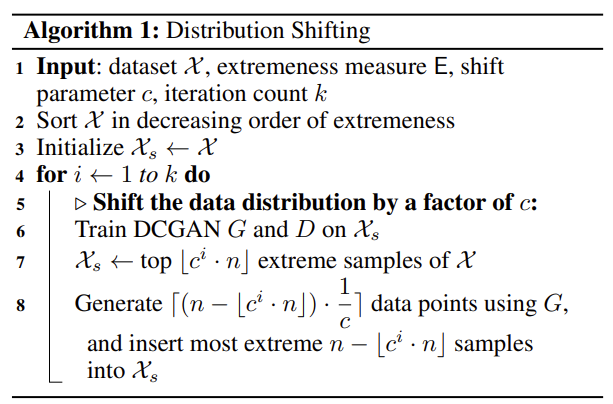
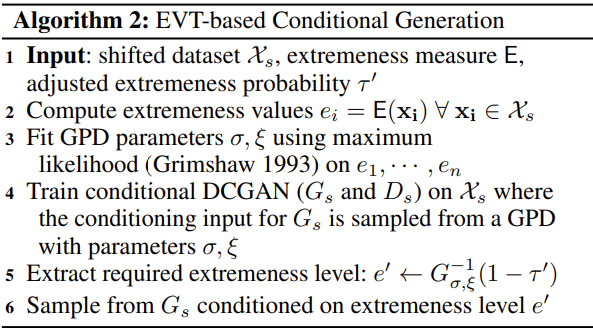

### Import Libraries

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from Distribution_Shifting import Distribution_Shifting
from GAN_Models import DCGAN
from Normalization import Normalizer
from BatchSize_Optimization import batch_size_optimization
from Evaluation_metrics import p_Wasserstein_distance
from scipy.stats import skewnorm, genpareto
from Conditional_GAN import Conditional_DCGAN

C:\Users\Haris\anaconda3\envs\pythonProject\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Loading Data for each tropical zone  - the datasets are the result of the Prepare_Data.py file ###

In [2]:
cur_dir = os.getcwd()
tropical_dataset = pd.read_csv(cur_dir + '\data\Tropical_dataset.csv')
subtropical_dataset = pd.read_csv(cur_dir + '\data\Subtropical_dataset.csv')
temperate_dataset = pd.read_csv(cur_dir + '\data\Temperate_dataset.csv')
polar_dataset = pd.read_csv(cur_dir + '\data\Polar_dataset.csv')

### Pipeline Class ###

In [3]:
class pipeline:
    def __init__(self, data, normalization_threshold, model, epochs, batch_size=128, Gloss_function=nn.L1Loss,
                 Dloss_function=nn.L1Loss):
        self.normalization_threshold = normalization_threshold
        self.batch_size = batch_size
        self.epochs = epochs
        self.best_batch_size = None
        self.Gloss_function = Gloss_function
        self.Dloss_function = Dloss_function
        normalizer = Normalizer(data, self.normalization_threshold)
        self.data, self.country_thresholds, self.countries_size_dict , self.orig_loss_data = normalizer.normalize()
        if model == 'DCGAN':
            self.model = model
        else:
            raise ValueError("Only DCGAN is supported at the moment")

    def batch_optimization(self, epochs=200, batch_size_list=[32, 64, 128, 256, 512], distance ='1-Wasserstein'):
        self.best_batch_size = batch_size_optimization(self.data, batch_size_list, epochs, self.model, distance)
        if self.model == "DCGAN":
            self.model = DCGAN(self.data, self.best_batch_size, self.epochs, self.Gloss_function, self.Dloss_function)
        
    def Distribution_Shifting(self, c, k):
        self.c = c
        self.k = k
        self.shifted_data = Distribution_Shifting(self.data, c, k, self.model)
        return self.shifted_data
    
    def fit_GPD(self,extremeness_measure):
        self.extremeness_measure = extremeness_measure
        self.measures = self.extremeness_measure(self.shifted_data)
        self.threshold = self.measures.min()
        self.tail = self.measures[np.where(self.measures > self.threshold)[0]]
        self.genpareto_params = genpareto.fit(self.tail - self.threshold)
        
    def train_Conditional_GAN(self):
        self.conditional_gan = Conditional_DCGAN(data = self.shifted_data,
                                                batch_size = self.best_batch_size,
                                                epochs = self.epochs,
                                                extremeness_measure = self.extremeness_measure,
                                                gen_pareto_params = self.genpareto_params,
                                                threshold = self.threshold,
                                                c = self.c,
                                                k = self.k,
                                                Gloss_function = self.Gloss_function,
                                                Dloss_function = self.Dloss_function)
        self.conditional_gan.train()
    
    def generate_samples(self,country,tau):
        try:
            number_of_samples = self.countries_size_dict[country]
        except:
            print("This country is not included in this climate zone. Pick another country")
            raise KeyError
        
        self.country = country
        self.gen_samples = self.conditional_gan.generate_samples(number_of_samples,tau)
        self.gen_samples = np.array(self.gen_samples).ravel() * self.country_thresholds[country]
        
        return self.gen_samples
    
    def plot_distribution_shifting_hist(self):
        plt.hist(self.shifted_data, bins=10 ,color= 'red')
        plt.title("Synthetic Data")
        plt.show()
        plt.hist(self.data, bins= 10, color = 'red')
        plt.title("Real Data")
        plt.show()
        
    def plot_hist(self):        
        plt.hist(self.gen_samples, bins=10 ,color= 'red')
        title = "Synthetic Data Generated for country " + self.country
        plt.title(title)
        plt.show()
        title2 = "Real Data for country " + self.country
        plt.hist(self.orig_loss_data[self.country], bins= 10, color = 'red')
        plt.title(title2)
        plt.show()

### Testing on Tropical Dataset ###

### Class Initilization, Dataset Normalization, Batch Optimization, Distribution Shifting ###

Initilize the class by providing :

- Dataset (Tropical, Subtropical, Polar, Temperate)
- Normalization Threshold for Exceedance Based Approach
- Epochs
- GAN model
- batch size
- Generator & Discriminator Loss Function

In [4]:
pipe = pipeline(tropical_dataset, 
               normalization_threshold = 0.3,
               model = 'DCGAN',
               epochs = 150,
               batch_size = 128,
               Gloss_function= nn.L1Loss,
               Dloss_function= nn.L1Loss)

Data were normalized using the exceedance based method with threshold:  0.3


Perform Batch Optimization

Input:

    1) epochs
    2) batch size list
    3) distance(evaluation metric)

In [5]:
pipe.batch_optimization(epochs = 10,
                       batch_size_list = [64,128,256],
                        distance = '1-Wasserstein')

Training the GAN with batch size:  64
Training the GAN with batch size:  128
Training the GAN with batch size:  256
The best batch size is 64 with a 1-Wasserstein distance of 37.8097


#### Distribution Shifting - Shift The Bulk of the Distribution to the tails

Data set Xs: Output of the first GAN model.  

Process:
1. Sort the data in decreasing order of extremeness.
2. Perform k iterations of distribution shifting - "k" user defined: 
- Train GAN using the whole dataset of Xs.
- Filter out the (1-c) points with smaller values from Xs. By performing this, our dataset now includes data points that are larger than the c-th percentile, where "c" is the distribution shifting parameter.
- In order to maintain the number of data points we use the GAN from Step 2.1. to generate a new dataset and use the largest values to fill the missing values that we removed in step 2.2.

Input:
    c = distribution shifting parameter
    k = number of iterations
    
    
Result:
1. This ensures that we choose the most extreme c proportion of the generated data, while bringing the dataset back to its original size of n data points.
2. Iteratively shifting the distribution in this way ensures that we always have enough data to train the GAN in a stable manner, while allowing us to gradually approach the tails of the distribution

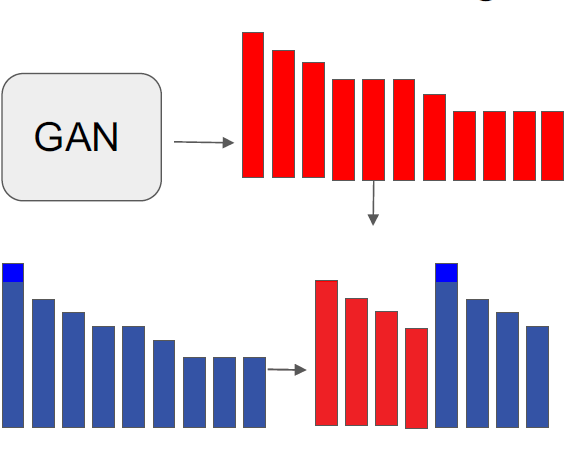

In [6]:
dist_shifting_parameter = 0.8
shifting_iterations = 3

synth_data = pipe.Distribution_Shifting(c = dist_shifting_parameter,k = shifting_iterations)

Distribution Shifting Started
Iteration:  1
The 1-Wasserstein distance between initial dataset and iteration 1 is:  23.347614248067668
Iteration:  2
The 1-Wasserstein distance between initial dataset and iteration 2 is:  39.93969923508311
Iteration:  3
The 1-Wasserstein distance between initial dataset and iteration 3 is:  79.95601801192748


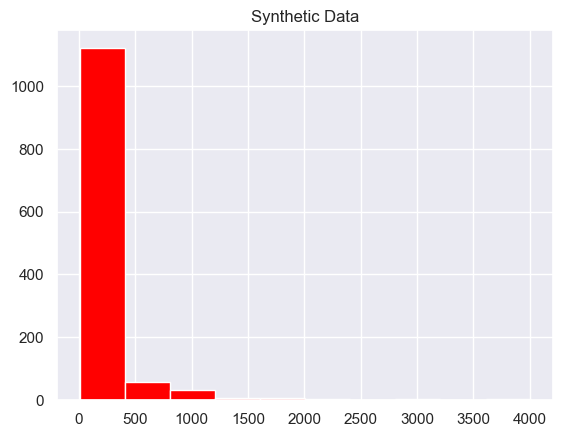

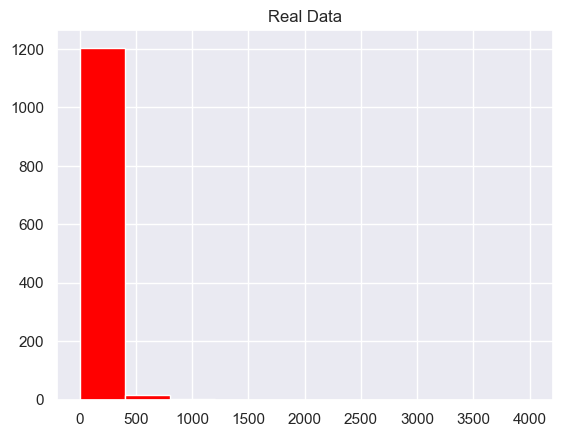

In [7]:
pipe.plot_distribution_shifting_hist()

## ExGAN - Conditional GAN: Generated Extreme Losses

- <b> Goal </b>: Generate samples at the user-given extremeness probability of tau ("τ").
- <b> Approach </b>: Train Conditional GAN, using an extremeness measure as conditioning variable. 
- <b> Level of extremenes at this point: </b> By performing distribution shifting we have achieved a level of extremeness of $ c^k $.

### Extreme Value Theory: Peaks over Threshold

Method of Extreme Value Analysis (EVA): extract, from a continuous record, the peak values for any period during which values exceed a certain threshold <i>u</i>.

Extreme Value Theory (EVT) states that the excess over a sufficiently large threshold <i>u</i>, denoted by <i> X - u </i>, is likely to follow a Generalized Pareto Distribution (GPD) with parameters σ(u), ξ. We will use this theorem in the next steps to fit a GPD and then draw samples from it.

In practice, the threshold u is set a value around the 95th percentile. However, we have already performed distribution shifting, for we will us the shifted dataset as our input and we will not apply an additional threshold. We will instead keep the lowest value of the dataset as an artificial threshold.

In [8]:
def extremeness_measure(shifted_data):
    shifted_data.sort()
    return shifted_data

#### Fit Generalized Pareto Distribution on Shifted Dataset based on the Peaks over Threshold theorem. 

By performing this, we are exctracting the values of σ, ξ parameters of the GPD distributions, using the maximum likelihood estimator. 

In [9]:
pipe.fit_GPD(extremeness_measure)

(shape, location, scale) = pipe.genpareto_params
print(f'Shape: {shape}, Location: {location}, Scale: {scale}')
print(f'Threshold: {pipe.threshold}')

Shape: 1.0781481956766426, Location: 0.009263431116696589, Scale: 21.863911963828695
Threshold: 7.032782515991471


Train Conditional GAN (G and D) on shifted dataset where the conditioning input for Gs is sampled from a GPD with the parameters estimated above.

In [10]:
pipe.train_Conditional_GAN()

Conditional GAN - Training started
Conditional GAN - Training finished


### EVT-based Conditional Generation 

#### Generate samples given an extremeness probability measure tau

Parameters:
- Extremeness measure - E[x]: For our case, since we are dealing with extreme data, i.e. losses caused by extreme events, our exremeness measure is the loss incurred as a result of the examined events.
- Extremeness probability - tau ("τ"): User defined value that is used to create generated data that reflect the level of desired extremenes τ. For example tau=0.001 denotes that the events that will be generated would on average be larger than 999 out of 1000 observations. 

As mentioned previsouly, we have already performed distribution shifting towards the tail of the distribution. Thus, achieving a level $ c^k $ of extremeness, where c denotes the level of shifting and k denotes the iterations of shifting. 

Prior to generating samples from the fitted Generalized Paretto Distribution (GPD) we will have to adjust the tau ("τ") user defined level of extremeness by performing: 

$ tau' = \frac{tau}{c^k}\ $


Additionally, we have added an additional loss function to the objective of the GAN: 

$ L_e = E[ \frac{| (e - E(G_s(z,e)) |}{e}] $

Where:
- e: is the extremeness value of each observation. In our case, it is the actual value of the loss
- Gs(z,e): sample from the generator, where z is sampled from a multivariate standard normal distribution
- E[Gs(z,e)]: extremeness measure of the generated sample, i.e. the actual value of the generated sample


In [11]:
tau = 0.0001

gen_samples = pipe.generate_samples('Sri Lanka',tau)

Number of samples generated:  31
Number of iterations:  31


### TODO: Extremeness probability (τ') vs Required Extremeness Level (e') 

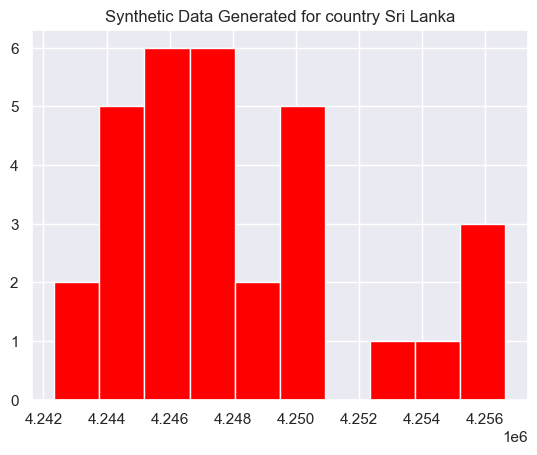

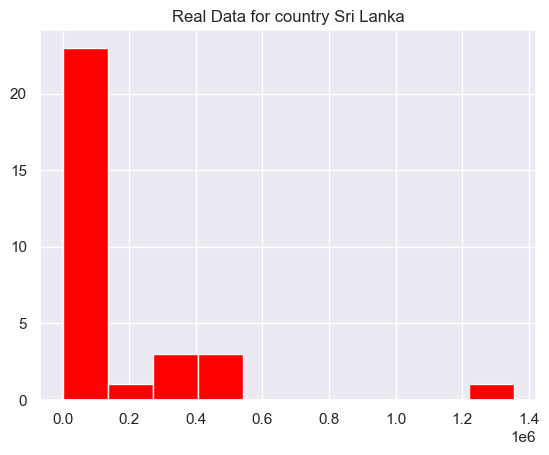

In [12]:
pipe.plot_hist()

In [13]:
pipe.gen_samples.mean()

4248142.5